### This notebook aims to show what the benchmark.jl and benchmark_glaciers.jl scripts do 

In [1]:
using Revise
using Distributed
using ProgressMeter
using OrdinaryDiffEq
using Random
using SugarBLAS
using Statistics: median
# using AbbreviatedStackTraces
using Logging: global_logger
using LinearAlgebra
using BenchmarkTools
using JLD2
using DataFrames
using TerminalLoggers: TerminalLogger
using Plots 
using StatsPlots
using CategoricalArrays 
global_logger(TerminalLogger())
    

include("../scripts/oggm_access.jl")
include("../scripts/1D_SIA.jl")
include("../scripts/1D_SIA_raw.jl") 

2023-05-25 18:29:25: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-05-25 18:29:25: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-05-25 18:29:25: oggm.cfg: Multiprocessing: using all available processors (N=16)
2023-05-25 18:29:26: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2023-05-25 18:29:26: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2023-05-25 18:29:26: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.


glacier_evolution_optim (generic function with 1 method)

### Functions for the benchmark (on both different glaciers and different solvers)

In [4]:
### FUNCTIONS ### 
function bench_solv(setting, gdir, reltol) #to benchmark the different solvers

    fls=gdir.read_pickle("model_flowlines")
    bed_o = fls[end].bed_h
    surface_o = fls[end].surface_h
    widths_o = fls[end].widths_m
    dx_o = fls[end].dx_meter

    bedlength = length(bed_o)

    diag = gdir.get_diagnostics()
    glen_a_o = diag["inversion_glen_a"]

    ude_benchmark = Dict("ude_settings"=>[], "time_stats"=>[],"time_stats_oggm"=>[])

    UDE_settings = Dict("reltol"=>reltol,"solver"=>[])
    UDE_settings["solver"] = setting

    println("Benchmarking UDE settings: ", UDE_settings)
    push!(ude_benchmark["ude_settings"], UDE_settings)
           
    t_stats = @benchmark glacier_evolution(gdir=$gdir, 
                                        dx=$dx_o, # grid resolution in m
                                        nx=$bedlength,  # grid size
                                        width=$widths_o,  # glacier width in m 
                                        glen_a= 2.4e-24,  # ice stiffness 2.4e-24
                                        n_years=2.0,  # simulation time in years
                                        solver = $setting,
                                        reltol=$reltol,
                                        bed_hs=$bed_o,
                                        surface_ini=$surface_o)

    # Save stats for each solver
    push!(ude_benchmark["time_stats"], t_stats)

    #also benchmarking oggm solution
    t_stats_o =@benchmark workflow.execute_entity_task(tasks.run_random_climate, $gdir, y0 = 2003, nyears=2,seed=1,store_fl_diagnostics=true)

            
    push!(ude_benchmark["time_stats_oggm"], t_stats_o)

    #=
    catch error
        println("ERROR: ", error)
        @warn "Solver not working. Skipping..."
    end
    =#

    GC.gc()
    return ude_benchmark
end

function bench_gla(rgi_id,reltol) #to benchmark the solvers on different glaciers
    
    reltol = reltol

    #Initialize glacier
    rgi = [rgi_id]
    gdirs=init_gdirs(rgi)
    gdir=gdirs[1]

    PARAMS["evolution_model"] = "FluxBased"
    tasks.init_present_time_glacier(gdir)

   #Benchmark every solver for one given glacier
    ude_solvers =[BS3(),CKLLSRK54_3C(),OwrenZen3(),RDPK3Sp35(),Ralston()]

    ude_benchmarks = pmap(ude_solver -> bench_solv(ude_solver, gdir, reltol), ude_solvers) 


    gla_benchmark= Dict("id"=>[], "solvers"=>[])
    push!(gla_benchmark["id"], rgi_id)
    push!(gla_benchmark["solvers"], ude_benchmarks)

    return gla_benchmark

end

bench_gla (generic function with 1 method)

## main function to do the benchmark

In [5]:
function BenchmarkingAll(filename) #to benchmark all the glaciers from the list on different solvers
    rgi_ids=["RGI60-11.03638","RGI60-11.03671","RGI60-11.03643","RGI60-11.03674","RGI60-11.03756", #Argentière, Gébroulaz, Mer de Glace,St-Sorlin, Sarennes
    "RGI60-16.00543","RGI60-16.01339", #Zongo, Antizana
    "RGI60-11.03232", #Ossoue
    "RGI60-15.03591", #Mera
    "RGI60-11.03646",
    "RGI60-14.07524", #Siachen
    "RGI60-01.05355"] #Alexander (Alaska)
    reltol = 1e-6
    results = pmap(r -> bench_gla(r,reltol), rgi_ids)

    save(filename, "data", results)

end 


BenchmarkingAll (generic function with 1 method)

In [ ]:
#Actually calling the benchmark
file= "../scripts/data/newbench100.jld2"
BenchmarkingAll(file)

### Looking at the results

In [2]:
file= "../scripts/data/newbench100.jld2"

"../scripts/data/newbench100.jld2"

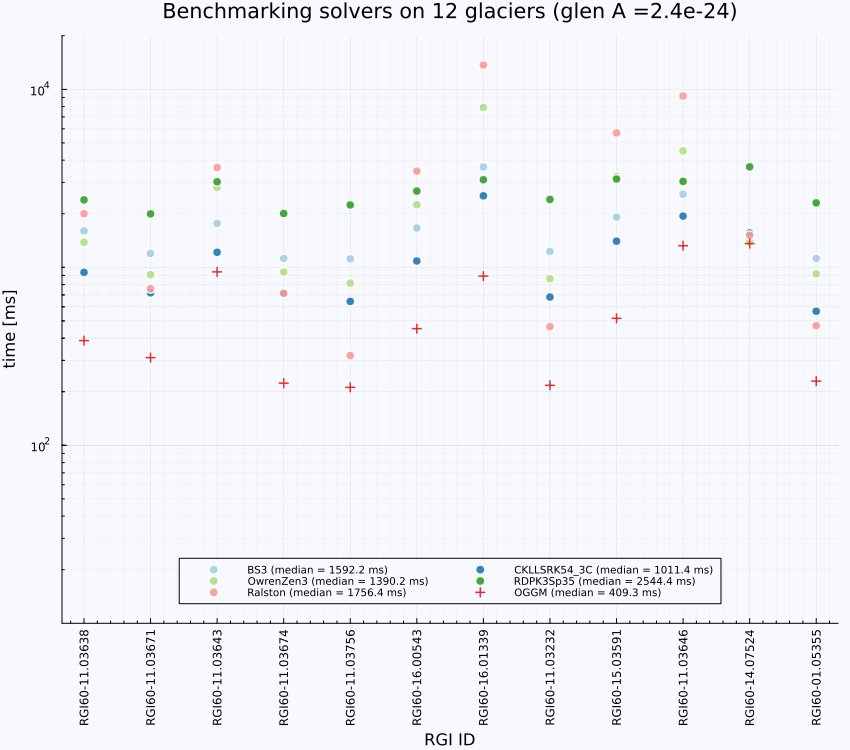

In [3]:
ude = load(file)
ude_solvers_str=["BS3","CKLLSRK54_3C","OwrenZen3","RDPK3Sp35","Ralston"]

rgi_ids=["RGI60-11.03638","RGI60-11.03671","RGI60-11.03643","RGI60-11.03674","RGI60-11.03756", #Argentière, Gébroulaz, Mer de Glace,St-Sorlin, Sarennes
    "RGI60-16.00543","RGI60-16.01339", #Zongo, Antizana
    "RGI60-11.03232", #Ossoue
    "RGI60-15.03591", #Mera
    "RGI60-11.03646",
    "RGI60-14.07524", #Siachen
    "RGI60-01.05355"] #Alexander (Alaska)

ng=length(rgi_ids)
ns= length(ude_solvers_str)

#Creating an adequate Dataframe with the results 
t_ms=[]
t_o =[]
mem=[]
mem_o=[]
for r=1:ng
    append!(t_ms,[mean(ude["data"][r]["solvers"][1][i]["time_stats"][1]).time*10^(-6) for i =1:ns]) #getting the data in the right order 
    append!(mem,[mean(ude["data"][r]["solvers"][1][i]["time_stats"][1]).memory*10^(-6) for i =1:ns])
    append!(t_o,[mean(ude["data"][r]["solvers"][1][i]["time_stats_oggm"][1]).time*10^(-6) for i =1:ns]) 
    append!(mem_o,[mean(ude["data"][r]["solvers"][1][i]["time_stats_oggm"][1]).memory*10^(-6) for i =1:ns])
        
end 

df=DataFrame(:id => repeat(rgi_ids,inner=ns),
                    :solv_name => repeat(ude_solvers_str,outer=ng),
                    :t_ms => t_ms,
                    :t_oggm_ms => t_o,
                    :memory_MiB => mem,
                    :memory_oggm_MiB => mem_o )

# Plotting 
m_oggm = round(median(df[:,:t_oggm_ms]),digits=1)
df_group = groupby(df,:solv_name)
label_solvers=ude_solvers_str
for k=1:ns
    med = round(median(df_group[k][:,:t_ms]),digits=1)
    label_solvers[k] = ude_solvers_str[k]*" (median = $med ms)"
end 

df.solv_name = categorical(df.solv_name)
gr(bg = :ghostwhite)
@df df scatter(:id,:t_ms,group=:solv_name,size=(850, 750),title="Benchmarking solvers on 12 glaciers (glen A =2.4e-24)",
                                            xlabel="RGI ID",xrotation=90,xtickfont=8, ylabel ="time [ms]",yscale=:log10,
                                            ylimits=(10,20000),minorgrid=true,legend=:bottom, legendcolumns=2,
                                            label=reshape(label_solvers, 1, :),legendfontsize=7,
                                                markershape=:circle,ma=0.9,markerstrokecolor = :white,palette=:Paired_9,ms=5)


df_group_o = groupby(df,:id)
df_t_o=[]
for l=1:ng
    med = round(median(df_group_o[l][:,:t_oggm_ms]),digits=1)
    append!(df_t_o,med)
end 

scatter!(rgi_ids, df_t_o,markershape=:cross,ma=0.9,markerstrokecolor = :white,label="OGGM (median = $m_oggm ms)",
                            palette=:Paired_9,ms=5)

